In [25]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2
import spatialpy
import numpy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
class All(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return True

class Walls(spatialpy.SubDomain):
    ''' Outside of the unit square'''
    def inside(self, x, on_boundary):
        if x[0] < 0.0 or x[0] > 1.0 or \
           x[1] < 0.0 or x[1] > 1.0:
            return True
        return False

In [133]:
class Simple_Diffusion(spatialpy.Model):
    """ 2D diffusion problem
    Description: box with Dirichlet boundary conditions in all 4 walls
    Top wall: concentration c_high
    All other walls: concentration c_low
    Wall lengths: height = 1, width = 1 (2D case)
  
                 cHigh
              __ __ __ __
             |           |
             |           |
       cLow  |           |  cLow
             |           |
             |__ __ __ __|
             
                 cLow
    
    """

    
    
    def __init__(self, model_name="simple_diffusion"):
        spatialpy.Model.__init__(self,model_name)
        
        
        # System constants
        cHigh = 1.           # concentration of species A on top wall
        cLow  = 0.           # concentration of species A on left, right and bottom walls
        nxF,nyF = 50,50      # number ofparticles in x and y-direction
        nu  = 0.1            # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 3              # number of wall points
        rho0 = 1.            # reference fluid density
        D = 0.01             # diffusion rate

        # Discretization
        nxTot = nxF + 2*nW # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*nW # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((0-(nW-1)*dx),1+(nW-1)*dx)
        yLim = ((0-(nW-1)*dy),1+(nW-1)*dy)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0  # in 2D simulations, consider z-lenght = 1
        mPP = rho0*vol/(nxTot*nyTot)                   # density * total volume / total number of particles

        # Define Species
        self.add_species(spatialpy.Species('A', diffusion_constant=D))

        # Create mesh object
        self.mesh = spatialpy.Mesh.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, 
            type_id=1, mass=mPP, rho0 = rho0, fixed=True)

        
        # Define Subdomains
        self.add_subdomain(All(), 1, mass = mPP, fixed=False)  # total subdomain, type 1
        self.add_subdomain(Walls(), 2, mass = mPP, fixed=True) # lid subdomain, type 2

        
        
        # We might want to add a way to impose intial conditions here (for determ. species)
        # ...
        
        
        # Boundary conditions
        # Bottom wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            ymin     = yLim[1],
            ymax     = yLim[1]+(nW-1)*dy,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Left wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin     = xLim[0],
            xmax     = xLim[0]+(nW-1)*dy,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Right wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin     = xLim[1]-(nW-1)*dy,
            xmax     = xLim[1],
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Top wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            ymin     = yLim[1]-(nW-1)*dy,  # top nW rows of particles
            ymax     = yLim[1]+1e-12,
            species = 'A',
            deterministic=True,
            value    = cHigh
        ))
        
        # Initial conditions (for discrete stochastic species)
        # Place the A molecules in the voxel nearest the center of the square
        #self.add_initial_condition(
        #    spatialpy.PlaceInitialCondition(A,100000,[0,0,0])
        #)
        #self.timespan(numpy.linspace(0,5,1000))

In [134]:
# Creates the model object
model = Simple_Diffusion()

(-0.04081632653061224, 1.0408163265306123)
totalvolume 1.1699291961682634


In [135]:
# Define time parameters
model.timestep_size = 1e-4  # timestep size
model.num_timesteps = 5000    # number of timesteps
model.output_freq = 100      # frequency of outputting results

In [136]:
# Run the model object
%time result = model.run()

CPU times: user 1min 2s, sys: 553 ms, total: 1min 2s
Wall time: 4min 31s


In [137]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
        print(len(d))
    else:
        d = data[key]
        print(len(d))
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    plt.grid(linestyle='--', linewidth=1)
    #plt.set_cmap('viridis') 


def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key)

read_step(50) opening '/var/folders/j0/bp87lk4162s4mjph030rc6hh0000gn/T/spatialpy_result_ntzjryfm/output5000.vtk'
3136


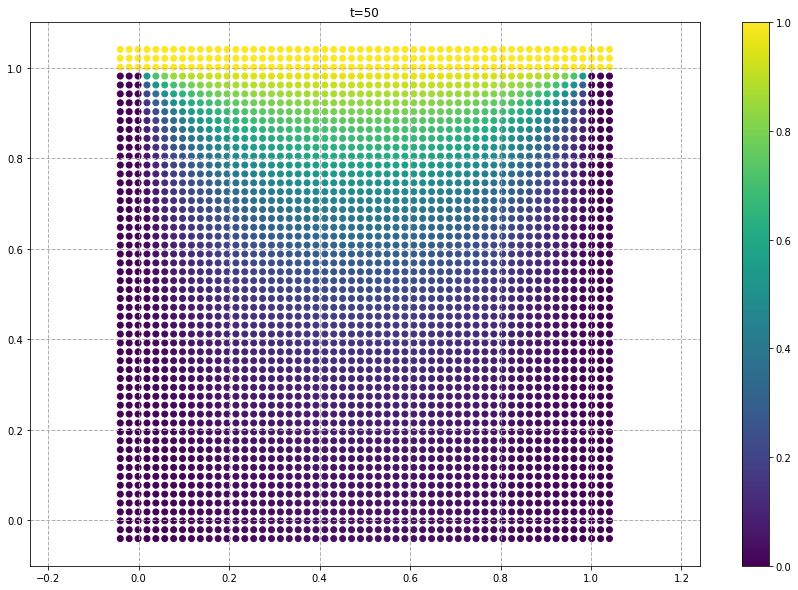

In [139]:
# Plot concentration of species A (discrete) at timestep 100
plot_step('C[A]',time=50)

In [ ]:
# To access data from a given timestep, use the read_step method
# e.g., read data from time step 10
pts,data = result.read_step(1)
print(pts)
print(data)